# Using a trained CNN model

In [604]:
from keras import models
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

DATA_FOLDER = '../oscilloscope/data/data_music/'

MODEL = './cnn_for_aed_20181108100417.h5'

with open(DATA_FOLDER+'class_labels.yaml', 'r') as f:
    class_labels = yaml.load(f)
class_labels

['blues_harp', 'classical_guitar', 'framenco_guitar', 'piano', 'tin_whistle']

In [605]:
model = models.load_model(MODEL)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 60, 36, 16)        416       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 30, 18, 16)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 26, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 13, 7, 32)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 2912)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2912)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                186432    
__________

In [606]:
FILTERED_MEL = b'3'
PORT = 'COM15'
BAUD_RATE = 921600

import sklearn.preprocessing as pp

def serial_read():
    ser = serial.Serial(PORT, BAUD_RATE)
    data = []
    id_ = 0
    n = 0
    
    ser.write(FILTERED_MEL)
    while True:
        line = ser.readline().decode('ascii')
        records = line[:-3].split(',')  # exclude the last ','
        delim = line[-2]  # exclude '\n'
        for r in records:
            data.append(int(r))
        if delim == 'e':
            break

    ser.close()
    data = pp.scale(np.array(data).astype(float))
    return data.reshape(1, 200, 40, 1)

In [657]:
data = serial_read()

(1, 200, 40, 1)

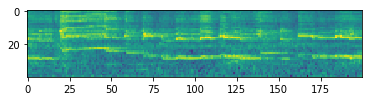

In [658]:
plt.imshow(np.rot90(data[0,:,:,0]))
data[:,:,:,:].shape

In [659]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(data[:,:64,:,:])

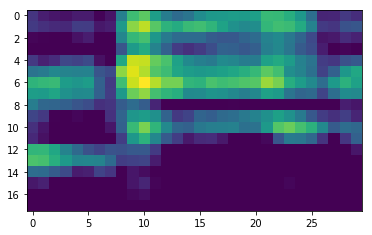

In [660]:
plt.imshow(np.rot90(activations[1][0,:,:,3]))

In [661]:
prediction_result = (activations[-1]*100).astype(int)

In [662]:
for p in prediction_result:
    i = np.argmax(p)
    print(p)
    print('this is {} ({}%)'.format(class_labels[i], p[i]))

[ 0  0  0  0 99]
this is tin_whistle (99%)
